# Build a `H3` grid for the San Diego region

## Infrastructure

To create a container that includes `h3` save the following on a file called `Dockerfile`:

```Dockerfile
FROM darribas/gds_dev:4.1

USER root
RUN wget -O - https://apt.kitware.com/keys/kitware-archive-latest.asc 2>/dev/null | sudo apt-key add - \
 && apt-add-repository 'deb https://apt.kitware.com/ubuntu/ bionic main' \
 && apt-get update \
 && apt-get install --yes cmake
USER $NB_UID
RUN pip install h3
```

And build the container by running the following from the same folder where the file is stored:

```
docker build -t gds_h3 .
```

When if finishes, you should be able to launch the `gds_h3` container and run this notebook from there.

In [1]:
%matplotlib inline

from h3 import h3
import geopandas
from shapely.geometry import Polygon
import contextily as ctx
import cenpy

## Region to cover

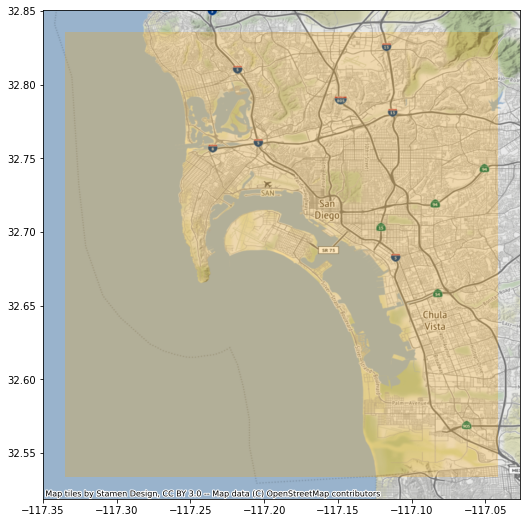

In [2]:
sd = geopandas.read_file("sd_city_centre.geojson")
ax = sd.plot(alpha=0.25, color="orange", figsize=(9, 9))
ctx.add_basemap(ax, crs=sd.crs.to_string())

## Build H3 geography

In [3]:
%time hexs = h3.polyfill(sd.geometry[0].__geo_interface__, 8, geo_json_conformant = True)

CPU times: user 8.19 ms, sys: 861 µs, total: 9.05 ms
Wall time: 10 ms


In [4]:
polygonise = lambda hex_id: Polygon(
                                h3.h3_to_geo_boundary(
                                    hex_id, geo_json=True)
                                    )

%time all_polys = geopandas.GeoSeries(list(map(polygonise, hexs)), \
                                      index=hexs, \
                                      crs="EPSG:4326" \
                                     )

CPU times: user 101 ms, sys: 7.66 ms, total: 109 ms
Wall time: 109 ms


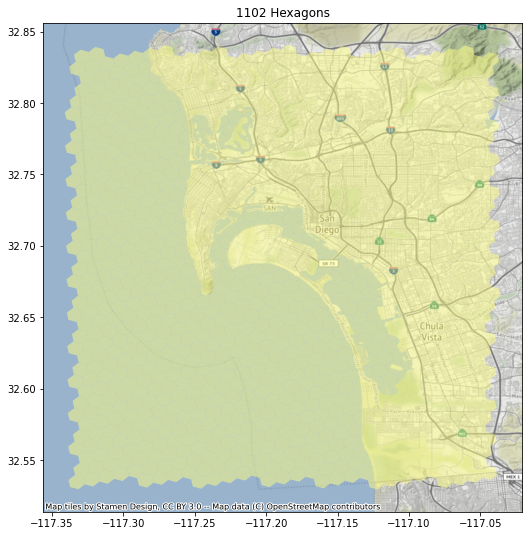

In [5]:
ax = all_polys.plot(alpha=0.5, color="xkcd:pale yellow", figsize=(9, 9))
ctx.add_basemap(ax, crs=all_polys.crs.to_string())
ax.set_title(f"{all_polys.shape[0]} Hexagons");

## Clip ocean out

There are quite a few hexagons that fall within the ocean. Let's get rid of them. For that, we will pull down the polygon for San Diego county using `cenpy`:

In [6]:
census = cenpy.Decennial2010()
tracts = census.from_msa("San Diego, CA", level="tract")

/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Now these geometries include also some ocean:

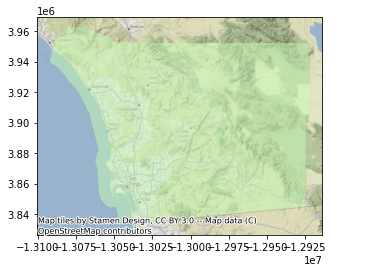

In [7]:
ax = tracts.plot(alpha=0.5, color="xkcd:pale green")
ctx.add_basemap(ax, crs=tracts.crs.to_string())

It turns out that part is a separate polygon that may be removed easily:

In [8]:
tracts.head()

,GEOID,geometry,NAME,state,county,tract
0,06073018200,"POLYGON ((-13066573.290 3920769.610, -13066530...","Census Tract 182, San Diego County, California",06,073,018200
1,06073018601,"POLYGON ((-13067719.770 3922939.420, -13067631...","Census Tract 186.01, San Diego County, California",06,073,018601
2,06073018000,"POLYGON ((-13064524.900 3917063.650, -13064338...","Census Tract 180, San Diego County, California",06,073,018000
3,06073017900,"POLYGON ((-13064042.110 3917657.290, -13064035...","Census Tract 179, San Diego County, California",06,073,017900
4,06073018510,"POLYGON ((-13064367.720 3923018.450, -13064295...","Census Tract 185.10, San Diego County, California",06,073,018510


In [9]:
tracts_land_one = geopandas.GeoDataFrame(
                        {"geometry": [tracts.query("GEOID != '06073990100'").unary_union],
                         "id": ["one"]
                        }, crs=tracts.crs)

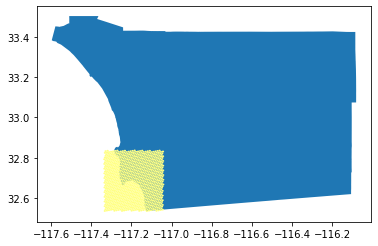

In [10]:
ax = tracts_land_one.to_crs(epsg=4269).plot()
all_polys.to_crs(epsg=4269).plot(color="xkcd:pale yellow", ax=ax)

Let's convert `all_polys` into a `GeoDataFrame`:

In [11]:
h3_all = geopandas.GeoDataFrame({"geometry": all_polys,
                                 "hex_id": all_polys.index},
                                crs=all_polys.crs
                               )

We're an overlay away from our target:

In [12]:
%%time
h3_land = geopandas.overlay(h3_all, 
                            tracts_land_one.to_crs(h3_all.crs), 
                            how="intersection"
                           )

CPU times: user 3.43 s, sys: 43 ms, total: 3.47 s
Wall time: 3.46 s


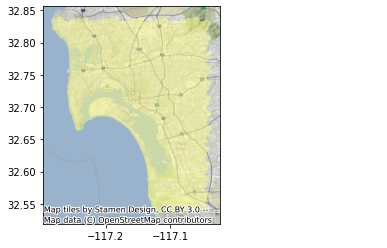

In [13]:
ax = h3_land.plot(alpha=0.5, color="xkcd:pale yellow")
ctx.add_basemap(ax, crs=h3_land.crs.to_string())

## Write out to `GPKG`

In [14]:
! rm sd_h3_grid.gpkg
h3_land.drop("id", axis=1).to_file("sd_h3_grid.gpkg", driver="GPKG")

## Tract Vs H3 geographies

Get tracts only within the grid:

In [15]:
shp = geopandas.GeoDataFrame(
    {"geometry": [h3_land.unary_union],
     "id": ["one"]
    }, crs = h3_land.crs).to_crs(tracts.crs)
sub = geopandas.overlay(tracts, shp, how="intersection")

Compare:

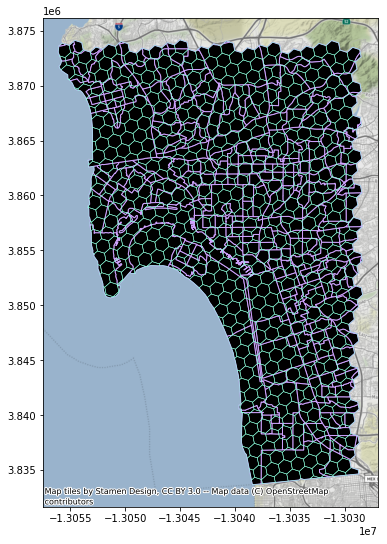

In [16]:
ax = sub.plot(facecolor="k", edgecolor="xkcd:lilac", figsize=(9, 9))
h3_land.to_crs(sub.crs).plot(facecolor="none", linewidth=0.5, edgecolor="xkcd:light aqua", ax=ax)
ctx.add_basemap(ax, crs=sub.crs.to_string())